<a href="https://colab.research.google.com/github/zeroesones/Spark/blob/master/pycon_pyspark_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distributed ML using PySpark


## Setup


In [0]:
# Install the packages below
!pip install numpy seaborn pandas matplotlib pyspark

     |████████████████████████████████| 215.7MB 121kB/s 
     |████████████████████████████████| 204kB 37.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=f9d820b13eeb6f0b8d02971c4da661a049ead88bbc99fc065113567b16aebd7c
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
# Make a data folder & download the data folder we'll be using for the project.
# NOTE: If you don't have wget, you can simply create data folder using file explore and place data from the following sources there
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [0]:
# imports to see if everything's fine
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

from pyspark.sql import SparkSession

### Starting a spark session

In [0]:
# Execute this only if the below cell is throwing java environment error
# import os
# os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/"

In [0]:
app_name = "hello_world"
# Running in the local model/

master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

In [0]:
# sc.stop()
help(sc)

Help on SparkContext in module pyspark.context object:

class SparkContext(builtins.object)
 |  Main entry point for Spark functionality. A SparkContext represents the
 |  connection to a Spark cluster, and can be used to create L{RDD} and
 |  broadcast variables on that cluster.
 |  
 |  .. note:: :class:`SparkContext` instance is not supported to share across multiple
 |      processes out of the box, and PySpark does not guarantee multi-processing execution.
 |      Use threads instead for concurrent processing purpose.
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |      Enable 'with SparkContext(...) as sc: app(sc)' syntax.
 |  
 |  __exit__(self, type, value, trace)
 |      Enable 'with SparkContext(...) as sc: app' syntax.
 |      
 |      Specifically stop the context on exit of the with block.
 |  
 |  __getnewargs__(self)
 |  
 |  __init__(self, master=None, appName=None, sparkHome=None, pyFiles=None, environment=None, batchSize=0, serializer=PickleSerializer(), co

You can take advantage of Spark UI to visualize stuff at: http://localhost:4040/jobs/

## Word count example

In [0]:
# Data source

corpus = [
    "Peter Piper picked a peck of pickled peppers",
    "a peck of pickled peppers Peter Piper picked",
    "if Peter Piper picked a peck of pickled peppers",
    "where’s the peck of pickled peppers that Peter Piper picked",
    "peck picker"
]

rdd = sc.parallelize(corpus)
rdd

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:195

In [0]:
# Performing the top operation
rdd

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:195

In [0]:
def emit_word_counts(line):
    # Split the line into words
    for word in line.split():
        # Return a tuple of word, count
        yield (word, 1)

# Applying the flatMap operation
word_count_emission_rdd = rdd.flatMap(emit_word_counts)

word_count_emission_rdd.take(3)

[('Peter', 1), ('Piper', 1), ('picked', 1)]

In [0]:
def aggregate_sum(value_so_far, current):
    return value_so_far + current

word_counts_rdd = word_count_emission_rdd.reduceByKey(lambda value_so_far, current: value_so_far + current)
word_counts_rdd.take(3)

[('of', 4), ('a', 3), ('where’s', 1)]

#### 3 different ways of getting the most occurring word

In [0]:
# Getting the most ocurred word in single line
# Using the sortBy operation on RDD
rdd.flatMap(emit_word_counts).reduceByKey(lambda x, y: x + y).sortBy(lambda x: -x[1]).collect()[0]

('peck', 5)

In [0]:
# Using the takeOrdered operation (implicity calls sortBy)
rdd.flatMap(emit_word_counts).reduceByKey(lambda x, y: x + y).takeOrdered(1, key=lambda x: -x[1])

[('peck', 5)]

In [0]:
# Using the countByKey operation (implicitly calls reduce) followed by Python's sorted method.
sorted(rdd.flatMap(emit_word_counts).countByKey().items(), key = lambda x: x[1], reverse=True)[0]

('peck', 5)

#### What was happening under the hood?

After `flatMap` is run, Spark collects the outputs (tuples) emitted by map, and performs optimized shuffling to distribute these emitted key-value pairs to the workers. 

Since `reduceByKey` aggregates the pairs based on the key, distribution happens in a such a way that all pairs corresponding to a particular key end up at the same worker. This means there's a "wide" dependency in the sense that Spark has to

- Wait for all the executors performing map function to finish and yield their outputs.
- Shuffle the map output.
- Send these outputs to the workers based on the key.

Thus the above job (lines → words → per-word count → global word count → output) is performed in two stages in Spark,

    Stage 1: lines → words → per-word count
    Stage 2: global word count → output


# Linear regression in PySpark

## 1. Gathering the data

For the main task we will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.

In [0]:
# make a data folder & download red & white wine files
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [0]:
# load the raw data into an RDD (Reading from a text file into an RDD)
# rdd = sc.textFile(data_file).filter(lambda x: x != header[0])

# Load raw data into csv
data_file = 'data/whites.csv'
df = spark.read.csv(data_file, header=True, sep=";", inferSchema=True);

FIELDS = df.columns
TARGET_FIELD = FIELDS[-1]
FEATURE_FIELDS = FIELDS[:-1]

rdd = df.rdd
rdd.take(2)

[Row(fixed acidity=7.0, volatile acidity=0.27, citric acid=0.36, residual sugar=20.7, chlorides=0.045, free sulfur dioxide=45.0, total sulfur dioxide=170.0, density=1.001, pH=3.0, sulphates=0.45, alcohol=8.8, quality=6),
 Row(fixed acidity=6.3, volatile acidity=0.3, citric acid=0.34, residual sugar=1.6, chlorides=0.049, free sulfur dioxide=14.0, total sulfur dioxide=132.0, density=0.994, pH=3.3, sulphates=0.49, alcohol=9.5, quality=6)]

## 2. EDA and feature selection

A statistician's approach to Linear Regression typically involves a series of EDA steps to **examine each feature** in the data and then series of steps to **test assumptions about their potential contribution to a multi-feature linear model**. 

In particular, we'd want to look for a set of features that
- Exhibit a likely linear relationship with the outcome variable 
- Are _not_ highy correlated with each other 

In the context of machine learning, these considerations remain important techniques for **improving model generalizability** despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

Next, we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

In [0]:
# Let's take a 1000 point sample for EDA
sample = np.array(rdd.takeSample(False, 1000))

# Creating a pandas dataframe for statistical analysis
sample_df = pd.DataFrame(sample, columns = FIELDS)

In [0]:
# Peeking into the data
sample_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.8,0.20,0.28,1.1,0.018,18.0,72.0,0.99260,2.97,0.35,10.4,5.0
1,6.2,0.24,0.27,2.9,0.039,30.0,123.0,0.98959,3.12,0.37,12.8,6.0
2,7.3,0.15,0.40,2.0,0.050,24.0,92.0,0.99320,3.14,0.45,10.5,5.0
3,7.8,0.43,0.49,13.0,0.033,37.0,158.0,0.99550,3.14,0.35,11.3,6.0
4,6.8,0.33,0.31,7.4,0.045,34.0,143.0,0.99226,3.06,0.55,12.2,6.0


### Univariate analysis

In [0]:
# Let's inspect the datatypes and null values
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
fixed acidity           1000 non-null float64
volatile acidity        1000 non-null float64
citric acid             1000 non-null float64
residual sugar          1000 non-null float64
chlorides               1000 non-null float64
free sulfur dioxide     1000 non-null float64
total sulfur dioxide    1000 non-null float64
density                 1000 non-null float64
pH                      1000 non-null float64
sulphates               1000 non-null float64
alcohol                 1000 non-null float64
quality                 1000 non-null float64
dtypes: float64(12)
memory usage: 93.9 KB


- Data has only float values.
- No variable column has null/missing values.

In [0]:
# Okay, time for a nice statistical summary
sample_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.89205,0.279100,0.33075,6.262550,0.045949,34.964000,138.041000,0.993966,3.189080,0.489580,10.539133,5.901000
std,0.80962,0.101473,0.11847,4.950321,0.021689,17.091704,42.295966,0.002830,0.150064,0.112471,1.211323,0.886558
min,4.40000,0.080000,0.00000,0.700000,0.012000,2.000000,24.000000,0.987420,2.790000,0.250000,8.000000,3.000000
25%,6.40000,0.210000,0.27000,1.600000,0.036000,23.000000,109.000000,0.991795,3.080000,0.410000,9.500000,5.000000
50%,6.80000,0.260000,0.31000,5.100000,0.043000,33.000000,133.500000,0.993645,3.180000,0.470000,10.400000,6.000000
75%,7.30000,0.320000,0.38000,9.700000,0.050000,45.250000,166.000000,0.995873,3.280000,0.540000,11.400000,6.000000
max,9.80000,1.100000,1.00000,20.700000,0.244000,138.500000,366.500000,1.002410,3.770000,1.060000,13.700000,8.000000


#### Observations
- Mean value is greater than median value of each column which is represented by 50%(50th percentile) in index column.
- There is notably a large difference between 75th %tile and max values of predictors “residual sugar”,”free sulfur dioxide”,”total sulfur dioxide”.

The above observations suggest that **there are extreme values-outliers** in our data set.

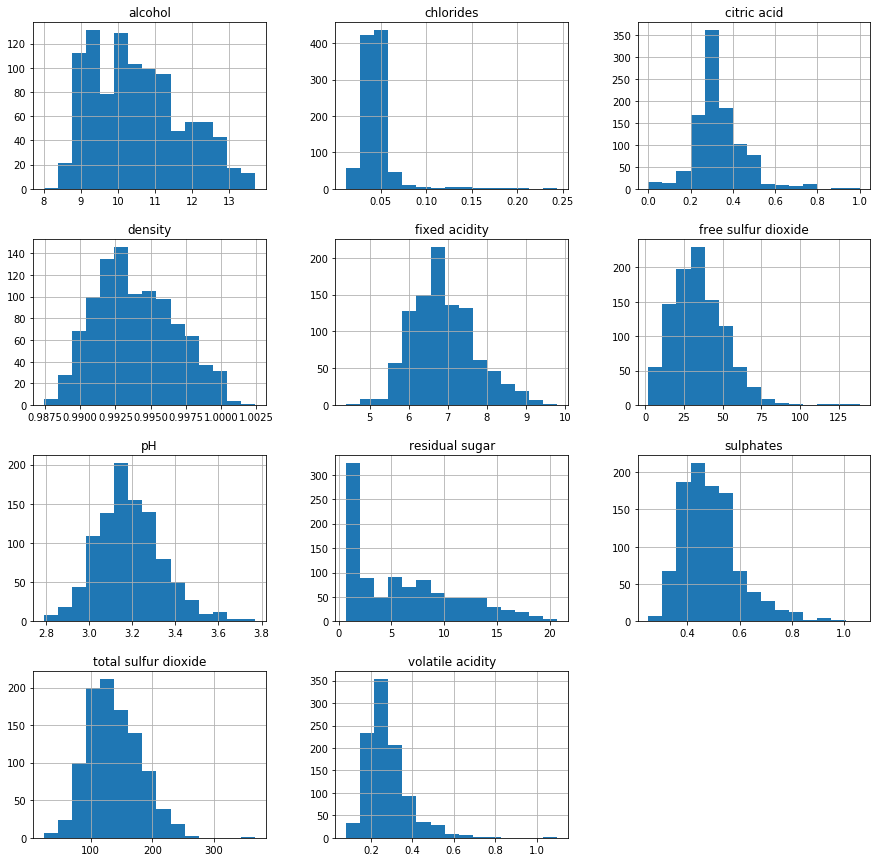

In [0]:
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

- “pH” and "density" columns appears to be normally distributed
- Remaining all independent variables are right skewed/positively skewed.
- The feature varying the most is 'alcohol'.

In [0]:
sample_df.quality.value_counts()

6.0    462
5.0    274
7.0    185
8.0     38
4.0     37
3.0      4
Name: quality, dtype: int64

- Target variable/Dependent variable is discrete and **categorical** in nature.
- 1,2 & 10 Quality ratings are not given by any observation. Only scores obtained are between 3 to 9.
- “quality” has most values concentrated in the categories 5, 6 and 7.

### Multivariate analysis

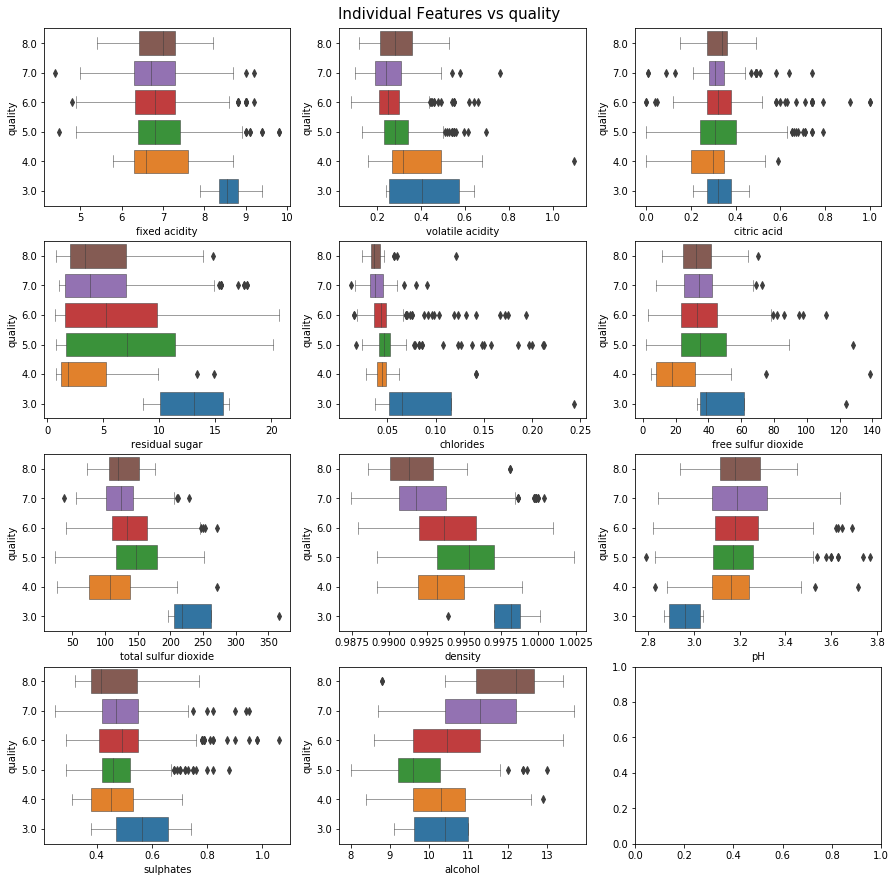

In [0]:
# plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))

y = sample_df[TARGET_FIELD]

for idx, feature in enumerate(FEATURE_FIELDS):
    x = sample_df[feature]
    # Plotting the box plot
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()

fig.suptitle(f"Individual Features vs {TARGET_FIELD}", fontsize=15, y=0.9)
plt.show()

The box plot (a.k.a. box and whisker diagram) is a standardized way of displaying the distribution of data based on the five number summary:

- Minimum
- First quartile
- Median
- Third quartile
- Maximum

A **segment** inside the rectangle shows the median and **“whiskers”** above and below the box show the locations of the minimum and maximum.

- Outliers are either 3×IQR or more above the third quartile or 3×IQR or more below the first quartile.

In our dataset, all features columns shows outliers.

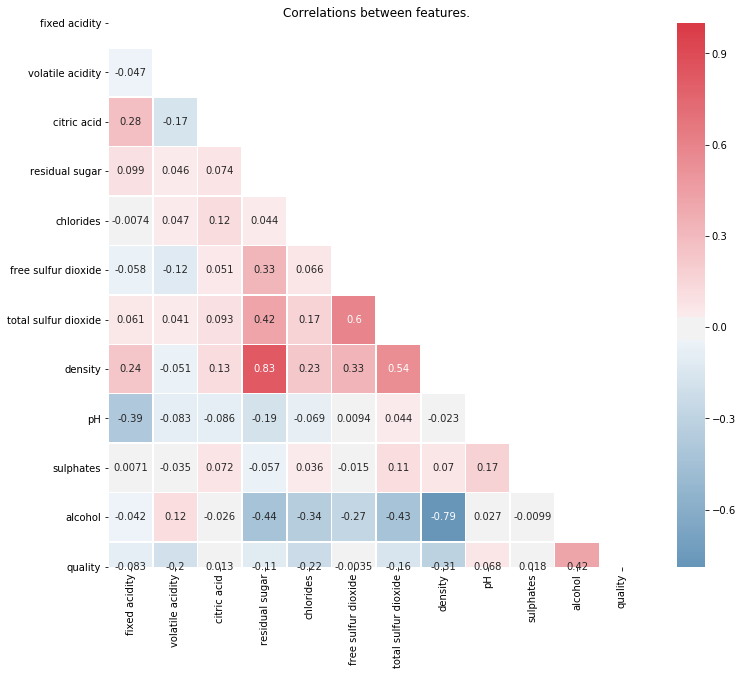

In [0]:
# plot heatmap for correlations matrix
corr = sample_df.corr()

fig, ax = plt.subplots(figsize=(12, 10))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True)

plt.title("Correlations between features.")
plt.show()

### Some observations
-  The total SO2 is correlated to free S02 (which is quite obvious).
- "Density" has strong positive correlation with "residual sugar" whereas it has strong negative correlation with "alcohol".
- "Sulphates" and "citric acid" has almost no correlation with "quality"


1. Features that are uncorrelated with respect to Target variable, possess less of an information regarding Target variable. Hence it is a good practice to remove such variables. 
2. Features that are correlated among themselves, which tend to give similar information. Hence are redundant and good to remove one of two depending their correlation with respect to target variable.

### Removing columns and preparing train-test split

In [0]:
columns_to_drop = ['sulphates', 'citric acid', 'density']
df = df.drop(*columns_to_drop)
FIELDS = df.columns
FEATURE_FIELDS = FIELDS[:-1]

In [0]:
FEATURE_FIELDS

['fixed acidity',
 'volatile acidity',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'pH',
 'alcohol']

In [0]:
# Ignore!
a, b = df.rdd.map(lambda x: (np.array(x[:-1], dtype="float"), x[-1])).cache().randomSplit([TRAIN_TEST_SPLIT, 1 - TRAIN_TEST_SPLIT], seed = 1)
a.collect()

[(array([7.00e+00, 2.70e-01, 2.07e+01, 4.50e-02, 4.50e+01, 1.70e+02,
         3.00e+00, 8.80e+00]), 6),
 (array([8.10e+00, 2.80e-01, 6.90e+00, 5.00e-02, 3.00e+01, 9.70e+01,
         3.26e+00, 1.01e+01]), 6),
 (array([7.20e+00, 2.30e-01, 8.50e+00, 5.80e-02, 4.70e+01, 1.86e+02,
         3.19e+00, 9.90e+00]), 6),
 (array([7.20e+00, 2.30e-01, 8.50e+00, 5.80e-02, 4.70e+01, 1.86e+02,
         3.19e+00, 9.90e+00]), 6),
 (array([8.10e+00, 2.80e-01, 6.90e+00, 5.00e-02, 3.00e+01, 9.70e+01,
         3.26e+00, 1.01e+01]), 6),
 (array([6.20e+00, 3.20e-01, 7.00e+00, 4.50e-02, 3.00e+01, 1.36e+02,
         3.18e+00, 9.60e+00]), 6),
 (array([6.30e+00, 3.00e-01, 1.60e+00, 4.90e-02, 1.40e+01, 1.32e+02,
         3.30e+00, 9.50e+00]), 6),
 (array([8.10e+00, 2.20e-01, 1.50e+00, 4.40e-02, 2.80e+01, 1.29e+02,
         3.22e+00, 1.10e+01]), 6),
 (array([8.10e+00, 2.70e-01, 1.45e+00, 3.30e-02, 1.10e+01, 6.30e+01,
         2.99e+00, 1.20e+01]), 5),
 (array([8.60e+00, 2.30e-01, 4.20e+00, 3.50e-02, 1.70e+01, 1.09e

In [0]:
def normalize(rdd):
    feature_means = rdd.map(lambda x: x[0]).mean()
    features_standard_dev = np.sqrt(rdd.map(lambda x: x[0]).variance())
    normed_rdd = rdd.map(lambda x: (np.subtract(x[0], feature_means) / features_standard_dev, x[1]))
    return normed_rdd

## 3. Train test split

In [0]:
# Split ratios
TRAIN_TEST_SPLIT = 0.8
split_ratios = [TRAIN_TEST_SPLIT, 1 - TRAIN_TEST_SPLIT]

# Remember: x[-1] is our label value, and x[:-1] are our feature values
rdd = df.rdd.map(lambda x: (np.array(x[:-1], dtype=float), x[-1]))
normalized_rdd = normalize(rdd)
train_rdd, test_rdd = normalized_rdd.randomSplit(split_ratios, seed=101)
print(f"Number of training records: {train_rdd.count()}\nNumber of testing records: {test_rdd.count()}")

Number of training records: 3920
Number of testing records: 978


In [0]:
train_rdd.take(3)

[(array([6.30e+00, 3.00e-01, 1.60e+00, 4.90e-02, 1.40e+01, 1.32e+02,
         3.30e+00, 9.50e+00]), 6),
 (array([8.10e+00, 2.80e-01, 6.90e+00, 5.00e-02, 3.00e+01, 9.70e+01,
         3.26e+00, 1.01e+01]), 6),
 (array([7.20e+00, 2.30e-01, 8.50e+00, 5.80e-02, 4.70e+01, 1.86e+02,
         3.19e+00, 9.90e+00]), 6)]

## Linear regression refresher


![https://miro.medium.com/max/1280/1*fX95txC9xSwSPeP6ch2nmg.gif](https://miro.medium.com/max/1280/1*fX95txC9xSwSPeP6ch2nmg.gif)

![https://www.jmp.com/en_hk/statistics-knowledge-portal/what-is-multiple-regression/fitting-multiple-regression-model/_jcr_content/par/styledcontainer_2069/par/lightbox_4130/lightboxImage.img.png/1548704005203.png](https://www.jmp.com/en_hk/statistics-knowledge-portal/what-is-multiple-regression/fitting-multiple-regression-model/_jcr_content/par/styledcontainer_2069/par/lightbox_4130/lightboxImage.img.png/1548704005203.png)

![https://vrzkj25a871bpq7t1ugcgmn9-wpengine.netdna-ssl.com/wp-content/uploads/2018/08/linear-regression-equation-explained.png](https://vrzkj25a871bpq7t1ugcgmn9-wpengine.netdna-ssl.com/wp-content/uploads/2018/08/linear-regression-equation-explained.png)



#### Choosing a baseline model

We'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. We'll reuse this function when we implement gradient descent.

In [0]:
# Using mean and variance operations on RDD
mean_target_value = train_rdd.map(lambda x: x[1]).mean()
target_variance = train_rdd.map(lambda x: x[1]).variance()
print(f"Mean: {mean_target_value}")
print(f"Variance: {target_variance}")

Mean: 5.876530612244912
Variance: 0.7847553102873795


In [0]:
# Baseline model
BASELINE = np.append([mean_target_value], np.zeros(len(train_rdd.take(1)[0][0]), dtype=np.float64))
print(BASELINE)

[5.87653061 0.         0.         0.         0.         0.
 0.         0.         0.        ]


### Defining the cost function

In [0]:
def squared_error(args):
    label, prediction = args[0], args[1]
    return (label - prediction)*(label - prediction)

def ols_loss(rdd, weights):
    """
    This method takes in rdd of the form `(features, label)` and a weights array of the dimensions 1 greater
    than features ("1" for bias), and returns the RMS error.
    """
    # Augmenting data for bias
    augmented_data = rdd.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmented_data.map(lambda x: (np.dot(x[0], weights), x[1])).map(squared_error).mean()
    return np.sqrt(loss)

In [0]:
print(f"Baseline model loss (RMSE): {ols_loss(train_rdd, BASELINE)}")

Baseline model loss (RMSE): 0.8858641601777211


## Vanilla Gradient Descent

![https://i.ytimg.com/vi/b4Vyma9wPHo/maxresdefault.jpg](https://i.ytimg.com/vi/b4Vyma9wPHo/maxresdefault.jpg)

Performing Gradient Descent technically only requires two steps:

1) _use the current model to calculate the gradient_

2) _use the gradient to update the current model parameters_. 

In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. Next, we'll implement gradient descent for OLS regression and take a look at a few update steps.

### Gradient descent formula for OLS regression

![https://camo.githubusercontent.com/f35bdd81399069b6e42a34577e4435efc03f05a7/68747470733a2f2f322e62702e626c6f6773706f742e636f6d2f2d5a784a383763576a504a382f54744c74777176306843492f41414141414141414156302f3946597163784a36644e592f73313630302f6772616469656e742b64657363656e742b616c676f726974686d2b4f4c532e706e67](https://camo.githubusercontent.com/f35bdd81399069b6e42a34577e4435efc03f05a7/68747470733a2f2f322e62702e626c6f6773706f742e636f6d2f2d5a784a383763576a504a382f54744c74777176306843492f41414141414141414156302f3946597163784a36644e592f73313630302f6772616469656e742b64657363656e742b616c676f726974686d2b4f4c532e706e67)



In [0]:
def gradient_descent_update(rdd, weights, lr=0.1):
    """
    Performs one gradient descent update. Returns updated coefficients,
    with bias at index 0.
    """
    # Add a feature of 1 corresponding to bias at index 0
    augmented_data = rdd.map(lambda x: (np.append([1.0], x[0].astype(np.float32, copy=False)), x[1])).cache()

    # First map yields a 3-tuple value (prediction, label, features)
    # Second map yields single value ""(prediction - label) * features"
    gradients = augmented_data\
                    .map(lambda x: (np.dot(x[0], weights), x[1], x[0]))\
                    .map(lambda x: np.dot(x[0]- x[1], x[2])) 
    
    total = gradients.count() # The m value
    sum_of_gradients = gradients.sum() # The summation
    
    # Update weights
    updated_weights = weights - lr * (1.0 / total) * sum_of_gradients
   
    return updated_weights

In [0]:
num_iterations = 15
model = BASELINE.astype(np.float32, copy=False)
print(f"BASELINE:  Loss = {ols_loss(train_rdd, model)}")

# Printing stats
for idx in range(num_iterations):
    print("----------")
    print(f"STEP: {idx+1}")
    model = gradient_descent_update(train_rdd, model)
    loss = ols_loss(train_rdd, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.8858641601777227
----------
STEP: 1
Loss: 0.8578808784171765
Model: [5.877, -0.009, -0.017, -0.009, -0.019, 0.0, -0.016, 0.008, 0.039]
----------
STEP: 2
Loss: 0.8379675036445661
Model: [5.877, -0.017, -0.033, -0.014, -0.034, 0.003, -0.028, 0.013, 0.072]
----------
STEP: 3
Loss: 0.8233907981412492
Model: [5.877, -0.023, -0.047, -0.016, -0.045, 0.007, -0.036, 0.018, 0.101]
----------
STEP: 4
Loss: 0.8123983359996368
Model: [5.877, -0.027, -0.06, -0.016, -0.055, 0.012, -0.043, 0.021, 0.126]
----------
STEP: 5
Loss: 0.8038679000732138
Model: [5.877, -0.031, -0.071, -0.015, -0.062, 0.017, -0.047, 0.023, 0.148]
----------
STEP: 6
Loss: 0.7970752054493251
Model: [5.877, -0.034, -0.081, -0.012, -0.067, 0.023, -0.05, 0.024, 0.168]
----------
STEP: 7
Loss: 0.791545594385954
Model: [5.877, -0.036, -0.09, -0.009, -0.072, 0.028, -0.052, 0.025, 0.185]
----------
STEP: 8
Loss: 0.7869613188901099
Model: [5.877, -0.038, -0.099, -0.005, -0.075, 0.033, -0.054, 0.026, 0.201]
---------

## 4. Training and evaluating the performance of our model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but **this number doesn't accurately reflect "how good" our model is.** 

Next, we'll plot error curves for a test and training set in order to discuss model performance.


In [0]:
# Combining everything into a function

def gradient_descent(train_rdd, test_rdd, initial_weights, num_iterations=20, 
                    lr = 0.001):   
    
    # tracking the history
    train_losses, test_losses, model_parameters = [], [], []

    model = initial_weights
    for idx in range(num_iterations): 
        # Compute gradients
        model = gradient_descent_update(rdd=train_rdd, weights=model)
        # Compute training loss
        training_loss = ols_loss(train_rdd, model)
        # Compute test loss
        test_loss = ols_loss(test_rdd, model)
        
        # Preserve history for later
        train_losses.append(training_loss)
        test_losses.append(test_loss)
        model_parameters.append(model)
        
        # Printing stats
        print("----------")
        print(f"STEP: {idx+1}")
        print(f"training loss: {training_loss}")
        print(f"test loss: {test_loss}")
        print(f"Model: {[round(w,3) for w in model]}")
        
    return train_losses, test_losses, model_parameters

In [0]:
# plot error curves
def plot_error_curve(train_losses, test_losses, title = None):
    fig, ax = plt.subplots(1, 1, figsize = (16,8))
    x = list(range(len(train_losses)))[1:]
    
    ax.plot(x, train_losses[1:], 'k--', label="Train loss")
    ax.plot(x, test_losses[1:], 'r--', label="Test loss")
    
    ax.legend(loc='upper right', fontsize='x-large')
    # Labels
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [0]:
%%time
# run 50 iterations
initial_weights = BASELINE
# train_rdd, test_rdd = normalized_rdd.randomSplit([0.8,0.2], seed = 4)
train_losses, test_losses, model_parameters = gradient_descent(train_rdd, test_rdd, initial_weights, num_iterations = 50)
print(f"\n... trained {len(train_losses)} iterations.")

----------
STEP: 1
training loss: 0.8578808784517404
test loss: 0.8577749127741728
Model: [5.877, -0.009, -0.017, -0.009, -0.019, 0.0, -0.016, 0.008, 0.039]
----------
STEP: 2
training loss: 0.8379675036961403
test loss: 0.8391157481128102
Model: [5.877, -0.017, -0.033, -0.014, -0.034, 0.003, -0.028, 0.013, 0.072]
----------
STEP: 3
training loss: 0.8233907981993713
test loss: 0.8256048283514236
Model: [5.877, -0.023, -0.047, -0.016, -0.045, 0.007, -0.036, 0.018, 0.101]
----------
STEP: 4
training loss: 0.8123983360583437
test loss: 0.8155203017710133
Model: [5.877, -0.027, -0.06, -0.016, -0.055, 0.012, -0.043, 0.021, 0.126]
----------
STEP: 5
training loss: 0.8038679001292927
test loss: 0.8077678361176553
Model: [5.877, -0.031, -0.071, -0.015, -0.062, 0.017, -0.047, 0.023, 0.148]
----------
STEP: 6
training loss: 0.7970752055012101
test loss: 0.801647052386773
Model: [5.877, -0.034, -0.081, -0.012, -0.067, 0.023, -0.05, 0.024, 0.168]
----------
STEP: 7
training loss: 0.791545594433026

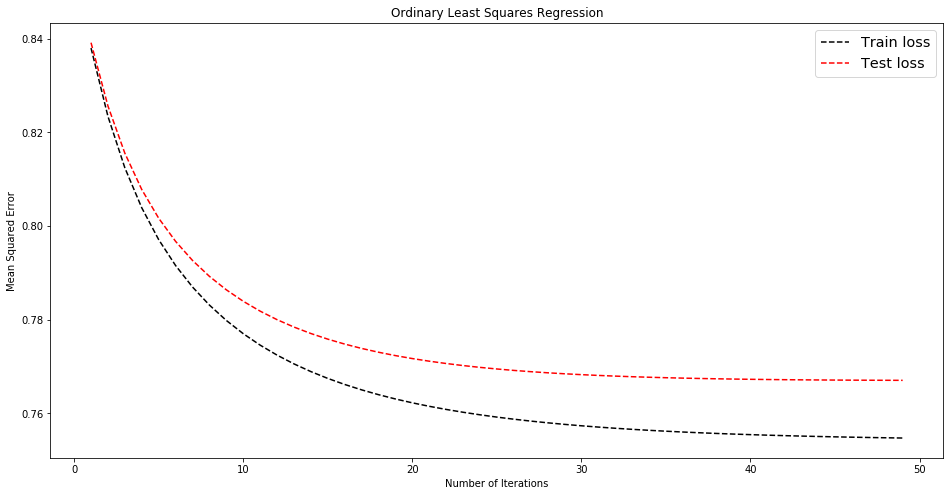

In [0]:
# take a look
plot_error_curve(train_losses, test_losses, title = 'Ordinary Least Squares Regression' )

In [0]:
# save the models & their performance for comparison later
# store path to notebook
PWD = !pwd
PWD = PWD[0]
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(model_parameters), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([train_losses, test_losses]), delimiter=',')

## Applying Cross Validation

Computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. **This "third step" however comes with a tradeoff: it requires an extra pass through the data.** Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place with no shuffle needed for the aggregation. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw previously, presents a bit more of a **scalability challenge**. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model.

The conventional k-fold cross-validation process is something like this,

    Shuffle and then split the dataset into k splits
    For iteration i in range 1 to k
        Hold out the ith split as test set
        Take the remaining splits as training sets
        Fit the model to the training set, evaluate score on the test set
        Retain the score and discard the model.
    Summarize the final scores.

![image.png](attachment:image.png)


A **naive approach** to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 data-splits in sequence. Naive appraoch will lead to **k-times increase** in the execution time because we'll be performing the training of folds sequentially.

#### Key observation

> If we observe carefully, each record in k-fold cross-validation is used in the train set 1 time and used to train the model k-1 times. To perform it parallelly in Spark, we can use k-models and update them simultaneously. In that way, we'll be making just one pass over the data records. 


### The approach

The `CV_loss` method takes in a list of data-splits and model weights and then iterates over the data splits.  It then computes residuals (Squared errors) for every record in the split using the `k_residuals` method. In the `k_residuals` method we compute the residuals for the data point against all the k models and label the ith residual as "test" (the others are labeled "train"). We'll emit a key to track this. So one iteration will emit key-value pairs of the form `[("1-test", 0.0123) ("2-train", 0.0345), …. ("k-train", kth_residual)]`. These key-value pairs are collected in the `partial_loss_rdd` by using a `union` operation to merge two RDDs. After that, we apply operations onto the `partial_loss_rdd` to compute the MSEs for train and test scenarios of every of the k models. Finally, we calculate the overall train and test loss by taking a mean across all the k models.

    Note: This is perhaps the hardest logical part to grasp that deals with intricacies of how to get things done with MapReduce paradigm. Half the battle of implementing any algorithm on Spark is about representing it in the form of map and reduce functions. It's all about taking the data, representing it in some form of key-value pairs by mapping, and then reducing those pairs to get the desired result.


#### Defining the k-fold loss function

In [0]:
# A way to compute train and test loss paralelly for all the k-models.
def k_residuals(record, k_models, current_split_num):
    """
    Compute the Squared errors for a data point given k different models. We emit
    a key (a "weird" one infact) to be able track the residuals for a model number and train/test type.
    """
    # As always, Augment the data point with a bias term at index 0
    X = np.append([1.0], record[0])
    y = record[1]
    
    for model_num, weights in enumerate(k_models):
        if model_num == current_split_num:
            # For the kth model, the record belonging to kth data split should be testing record. 
            yield(f"{model_num}-test", (weights.dot(X) - y) ** 2)
        else:
            # For the kth model, the rest of the records are training records
            yield(f"{model_num}-train", (weights.dot(X) - y) ** 2)

In [0]:
from collections import Counter

def CV_loss(data_splits, models):
    """
    Computes the k-fold cross-validated test and train loss.
    data-splits is a list of k data pieces.
    """
    # For each record, compute k squared errors i.e. residuals  (one for each model)
    # These residuals will be stored in the following rdd
    # Why are we doing this? To compute the training losses parallely
    partial_loss_rdd = sc.parallelize([])
    
    # Iterating over k-data pieces
    for split_num, rdd in enumerate(data_splits):
        # Compute residuals for both training and testing in one-go
        residuals = rdd.flatMap(lambda x: k_residuals(x, models, split_num))
        # Preserve them, union operation is used to combine rows of two or more rdds
        partial_loss_rdd = sc.union([partial_loss_rdd, residuals])
    
    # Aggreate the loss
    # First map puts the loss value in a list
    # Then the reduce function appends those lists
    # And finally another map to compute the mean
    loss = partial_loss_rdd.map(lambda x: (x[0], [x[1]]))\
            .reduceByKey(lambda x, y: x + y)\
            .map(lambda x: (x[0], np.mean(x[1]))).collect() 
    
    # Now is the time to use those "weird" keys to get mean value of losses for training and testing
    test_loss = np.sqrt(np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test']))
    training_loss = np.sqrt(np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train']))
    return training_loss, test_loss

#### Defining the gradient descent logic

In [0]:
def partial_gradient(split_num, record, models):
    """
    Emit partial gradient for this record for each model.
    """
    # augment the data point
    X = np.append([1.0], record[0])
    y = record[1]
    # emit partial gradients for each model with a counter for averaging later
    for model_num, weights in enumerate(models):
        if model_num != split_num:
            # Emit tuples of the form (k, [(prediction, count)])
            # count will later be used to compute mean
            yield (model_num, [(weights.dot(X) - y)*X, 1])

In [0]:
def CV_update(data_splits, models, lr = 0.01):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partials_rdd = sc.parallelize([])
    
    # NOTE that we're still in-essence doing one pass over entire data
    for split_num, rdd in enumerate(data_splits):
        one_fold_partial_grads =  rdd.flatMap(lambda x: partial_gradient(split_num, x, models))
        partials_rdd = sc.union([partials_rdd, one_fold_partial_grads])

    # compute gradients by taking the average partialGrad for each fold
    # We've used mapValues because we don't care about keys here.
    gradients = partials_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for weights, grad in zip(models, gradients):
        new_model = weights - lr * grad
        new_models.append(new_model)
    return new_models

Notice that we've used `mapValues` instead of `map`. If your map method doesn't use the keys, then you can use `mapValues` to get some performance gain. Remember that the keys are not lost anywhere, and we're using them in the next map function `(lambda x: x[1])` in the snippet above. Also, notice how we've used 1 in `partial_gradient` method to be able to compute the total count in `reduceByKey` operation of `CV_update` method (similar to what we did for word count).

In [0]:
def gradient_descent_with_cv(data_splits, initial_weights, lr=0.01, num_iterations = 5):
    """
    Train k models in parallel and track cross validated test/train loss.
    """
    # broadcast initial models (one for each fold)
    broadcasted_models = sc.broadcast([initial_weights] * len(data_splits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CV_loss(data_splits, broadcasted_models.value)
    train_losses, test_losses, model_params = [train_loss_0], [test_loss_0], [initial_weights]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(num_iterations):
        new_models = CV_update(data_splits, broadcasted_models.value, lr)
        broadcasted_models = sc.broadcast(new_models)

        # Calculate loss and log the progress
        train_loss, test_loss = CV_loss(data_splits, broadcasted_models.value)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        model_params.append(new_models[0])
        
        print("-------------------")
        print(f"STEP {step}: ")
        print(f"model 1: {[round(w,4) for w in new_models[0]]}")
        print(f" train loss: {train_loss}")
        print(f" test loss: {test_loss}")
            
    return train_losses, test_losses, model_params

The training logic is similar to the vanilla gradient descent which we performed previously, except for the one thing, broadcasting. What is broadcasting and why do we need it? 

While invoking the `CV_loss` method, we pass a list of RDDs and a list of model weights. Then we iterate over the RDDs in `CV_loss` method and pass the same list of models to `CV_update`. Since operations on these different RDDs may end up on different executors, we'll have to ship a copy of the list of model-weights to every executor whenever the tasks are scheduled. But by broadcasting the list of model weights, Spark will cache a distributed copy of the list on every worker, so that it doesn't get shipped every time, preventing the communication overhead.

In [0]:
# run 50 iterations
data_splits = normalized_rdd.randomSplit([1.0 / 6]*6, seed = 2018) 
initial_weights = BASELINE
start = time.time()
train_losses, test_losses, model_parameters = gradient_descent_with_cv(data_splits, initial_weights, num_iterations=50)
print(f"\n... trained {len(train_losses)} iterations in {time.time() - start} seconds")

-------------------
STEP 0: 
model 1: [5.8765, -0.0009, -0.0018, -0.0009, -0.0018, 0.0001, -0.0015, 0.0008, 0.0038]
 train loss: 0.8826034441806805
 test loss: 0.882696728365682
-------------------
STEP 1: 
model 1: [5.8765, -0.0018, -0.0035, -0.0017, -0.0035, 0.0001, -0.003, 0.0017, 0.0076]
 train loss: 0.8797477125491603
 test loss: 0.8798756594360863
-------------------
STEP 2: 
model 1: [5.8764, -0.0027, -0.0053, -0.0025, -0.0052, 0.0002, -0.0045, 0.0025, 0.0113]
 train loss: 0.87698110311577
 test loss: 0.8771428626645794
-------------------
STEP 3: 
model 1: [5.8764, -0.0036, -0.007, -0.0032, -0.0069, 0.0004, -0.0059, 0.0033, 0.015]
 train loss: 0.8743004118549552
 test loss: 0.8744951597860938
-------------------
STEP 4: 
model 1: [5.8764, -0.0045, -0.0087, -0.0039, -0.0085, 0.0005, -0.0072, 0.004, 0.0186]
 train loss: 0.8717025496498247
 test loss: 0.8719294868172563
-------------------
STEP 5: 
model 1: [5.8763, -0.0053, -0.0104, -0.0046, -0.0101, 0.0006, -0.0085, 0.0048, 0.02

-------------------
STEP 46: 
model 1: [5.8754, -0.0283, -0.0663, -0.0121, -0.0529, 0.0163, -0.0401, 0.0233, 0.1336]
 train loss: 0.8093734532509456
 test loss: 0.8104789359203721
-------------------
STEP 47: 
model 1: [5.8754, -0.0287, -0.0674, -0.012, -0.0536, 0.0168, -0.0405, 0.0236, 0.1356]
 train loss: 0.8085608186896385
 test loss: 0.80968015413714
-------------------
STEP 48: 
model 1: [5.8754, -0.029, -0.0685, -0.0118, -0.0542, 0.0173, -0.0409, 0.0238, 0.1377]
 train loss: 0.8077662367271542
 test loss: 0.8088992287641409
-------------------
STEP 49: 
model 1: [5.8754, -0.0294, -0.0696, -0.0116, -0.0548, 0.0178, -0.0412, 0.024, 0.1397]
 train loss: 0.8069891553651563
 test loss: 0.8081356135652412

... trained 51 iterations in 36.44716215133667 seconds


As we can observe, for 6-fold cross-validation, the training time increased by a factor of 3.5, although we still made only 1-pass over the data points. A few reasons for the increase in execution time are,

    We were computing residuals for 6 different models instead of one.
    The tasks are not entirely independent.
    I have only four cores in my CPU which limits the parallelization.

After all these limitations, we've performed pretty well. If we had gone with the sequential approach of performing 6-fold cross-validation, we'd have taken 6x more time.

Now let's see by plotting the error curve if we were able to narrow down the gap between test and training error values.

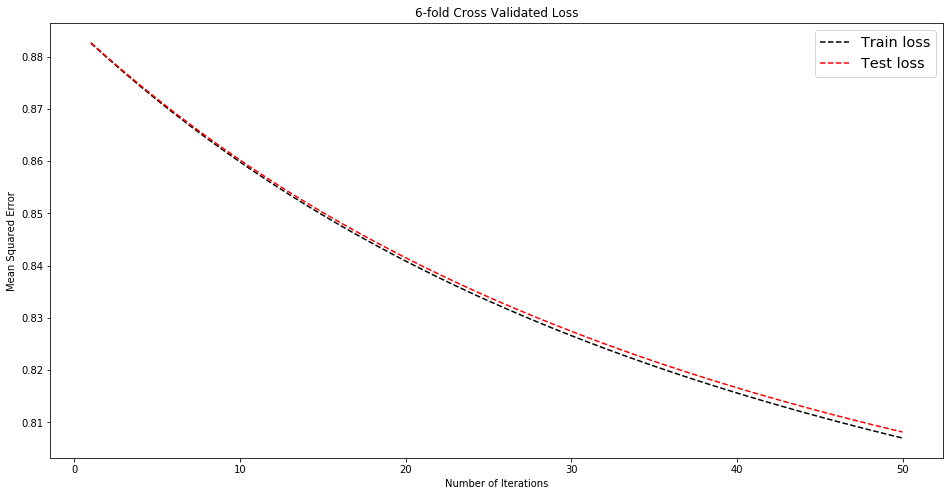

In [0]:
# plot
plot_error_curve(train_losses, test_losses, title = '6-fold Cross Validated Loss' )

In [0]:
# plotting function
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show

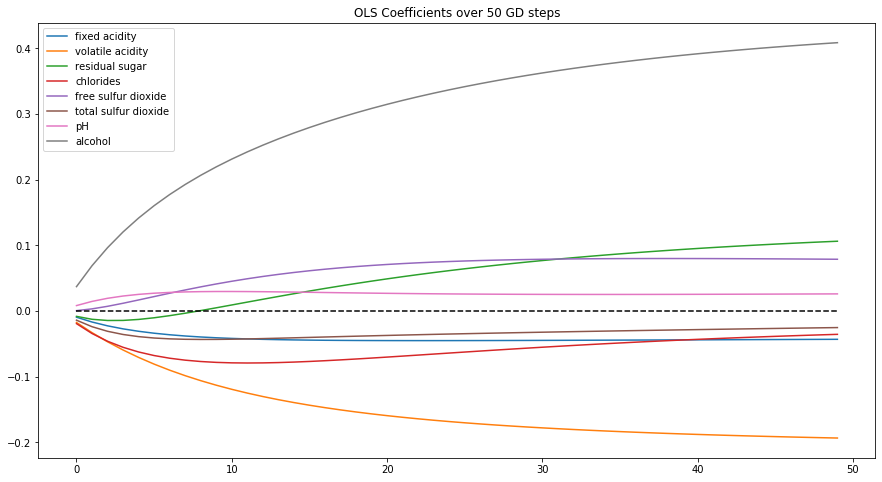

In [0]:
# take a look 
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

#### Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are $2^{p}$ potential models that can be built from $p$ features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. Following are the implementations of Gradient Descent with ridge and lasso regularization.

__`NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).


### Congratulations!

# The larger picture

## Linear regression in 2019 style

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

# Define various stages
vectorAssembler = VectorAssembler(inputCols=FIELDS[:-1], outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=50, regParam=0.3, labelCol=TARGET_FIELD)

# Create a pipleline
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)

# Train test split
(training, test) = df.randomSplit([.7, .3])

# Pass the data through the pipeline
model = pipeline.fit(training)

In [0]:
lr_model = model.stages[-1]
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

# Summarize the model over the training set and print out some metrics
training_summary = lr_model.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)

Coefficients: [-0.035942069325676014,-0.13001304962133392,-0.04961434261432295,0.06422860600450925,-0.02511136491250901,-0.03966005708554136,0.014578320014234779,0.257153379377147]
Intercept: 17.457676606635896
RMSE: 0.786717


In [0]:
prediction = model.transform(test)

prediction.select("features", "quality", "prediction").show(5)

+--------------------+-------+-----------------+
|            features|quality|       prediction|
+--------------------+-------+-----------------+
|[5.70006408874801...|      7|6.426741215381444|
|[5.70006408874801...|      6|6.300276223226765|
|[5.70006408874801...|      6|5.795769545221079|
|[5.81881542393026...|      5|5.762909705208267|
|[5.93756675911251...|      6|6.490840158449526|
+--------------------+-------+-----------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=TARGET_FIELD, predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = evaluator.evaluate(prediction)
print("RMSE: %.3f" % rmse)

# r2 - coefficient of determination
r2 = evaluator.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 0.746
r2: 0.746


### Cross validation and hyperparameter tuning

In [0]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: quality)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100, current: 50)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.3)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize th

In [0]:
%%time

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.1, 0.01, 0.0]) \
    .addGrid(lr.regParam, [0.25, 0.1, 0.01]) \
    .build()

# Cross validation with model parallelism
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=6,
                          parallelism=2)

cv_model = crossval.fit(training)


best_model = cv_model.bestModel



lr_model = best_model.stages[-1]

print("Regularization param selected:", lr_model.extractParamMap())
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

# Summarize the model over the training set and print out some metrics
training_summary = lr_model.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)

Regularization param selected: {Param(parent='LinearRegression_86565e2152bb', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LinearRegression_86565e2152bb', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LinearRegression_86565e2152bb', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35, Param(parent='LinearRegression_86565e2152bb', name='featuresCol', doc='features column name'): 'features', Param(parent='LinearRegression_86565e2152bb', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LinearRegression_86565e2152bb', name='labelCol', doc='label column name'): 'quality', Param(parent='LinearRegression_86565e2152bb', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)')

In [0]:
prediction = cv_model.transform(test)

rmse = cv_model.getEvaluator().evaluate(prediction)
print("RMSE: %.3f" % rmse)

RMSE: 0.730


### Persisting and applying models

In [0]:
cv_model.bestModel.write().overwrite().save("data/cv_model")

In [0]:
# Info stored in an open source file format for Hadoop ecosystem called "Paraquet"
!ls data/cv_model/metadata

_SUCCESS   part-00000


In [0]:
from pyspark.ml import PipelineModel
loaded_pipeline = PipelineModel.load("data/cv_model")

In [0]:
loaded_pipeline.stages[-1].coefficients

DenseVector([-0.0745, -0.1863, -0.0257, 0.0823, -0.0291, 0.1331, -0.0077, 0.4897])